In [1]:
import sys
sys.path.append('../')
from src.load_data import *
from src.plot_functions import *
from src.hp_tuning_functions import *

from darts.dataprocessing.transformers import Scaler
from darts.dataprocessing.transformers.mappers import InvertibleMapper

from darts.models.forecasting.sf_auto_arima import StatsForecastAutoARIMA as AutoARIMA

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


# Load data

In [2]:
TEST_YEAR = 2019

In [3]:
targets_train, targets_validation, covariates = get_test_data(TEST_YEAR)

<Axes: xlabel='date'>

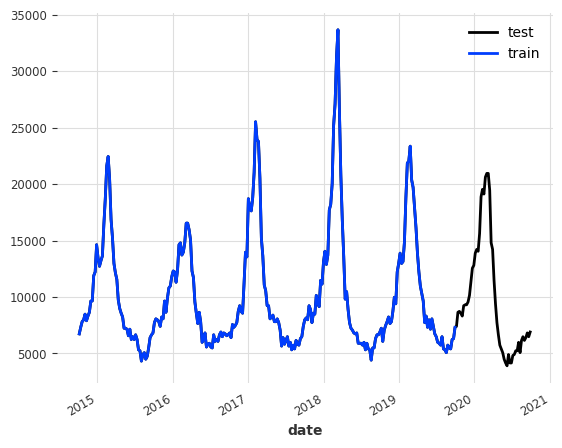

In [4]:
targets_validation['icosari-sari-DE'].plot(label='test')
targets_train['icosari-sari-DE'].plot(label='train')

# Log transformation

In [5]:
transformer = InvertibleMapper(lambda x: np.log(x + 1), 
                               lambda x: np.exp(x) - 1)

In [6]:
targets_train = transformer.transform(targets_train)

In [7]:
targets_validation = transformer.transform(targets_validation)

# ARIMA

In [8]:
encoders = {
    'cyclic': {'future': ['month', 'weekofyear']},
    'position': {'future': ['relative']},
    #'transformer': Scaler()
}

In [9]:
arima = AutoARIMA(
    # max_p = 55
    # add_encoders=encoders
)

In [10]:
arima_models = {}
for target in TARGETS:
    arima_models[target] = arima

In [11]:
validation_start = targets_train.end_time() + targets_train.freq

In [12]:
backtests = {}
for target in arima_models.keys():
    backtest = arima_models[target].historical_forecasts(
        series=targets_validation[target],
        start=validation_start,
        forecast_horizon=4,
        stride=1,
        last_points_only=False,
        retrain=True,
        verbose=True,
        num_samples=100,
        enable_optimization=False
    )
    
    backtests[target] = backtest

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

In [13]:
for b in backtests.keys():
    backtests[b] = transformer.inverse_transform(backtests[b])

In [14]:
targets_validation = transformer.inverse_transform(targets_validation)

In [15]:
df = reshape_hfc(backtests)

In [19]:
df.to_csv('../data/pre-covid/arima_scaled-2019.csv', index=False)

In [16]:
df_plot = prepare_plot_data(df, targets_validation[validation_start : ])

### With log transformation

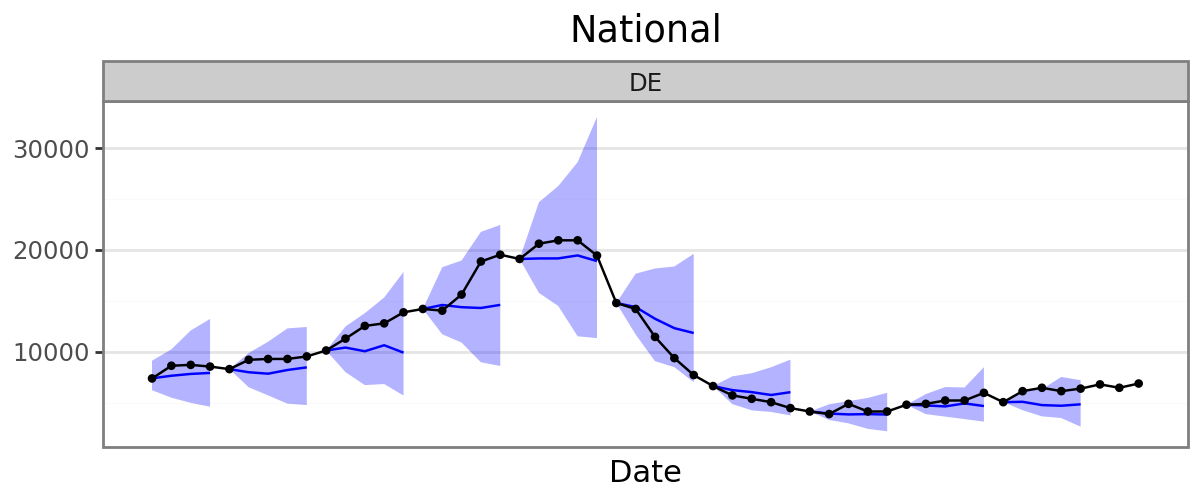

In [17]:
plot_forecasts(df_plot, 'national')

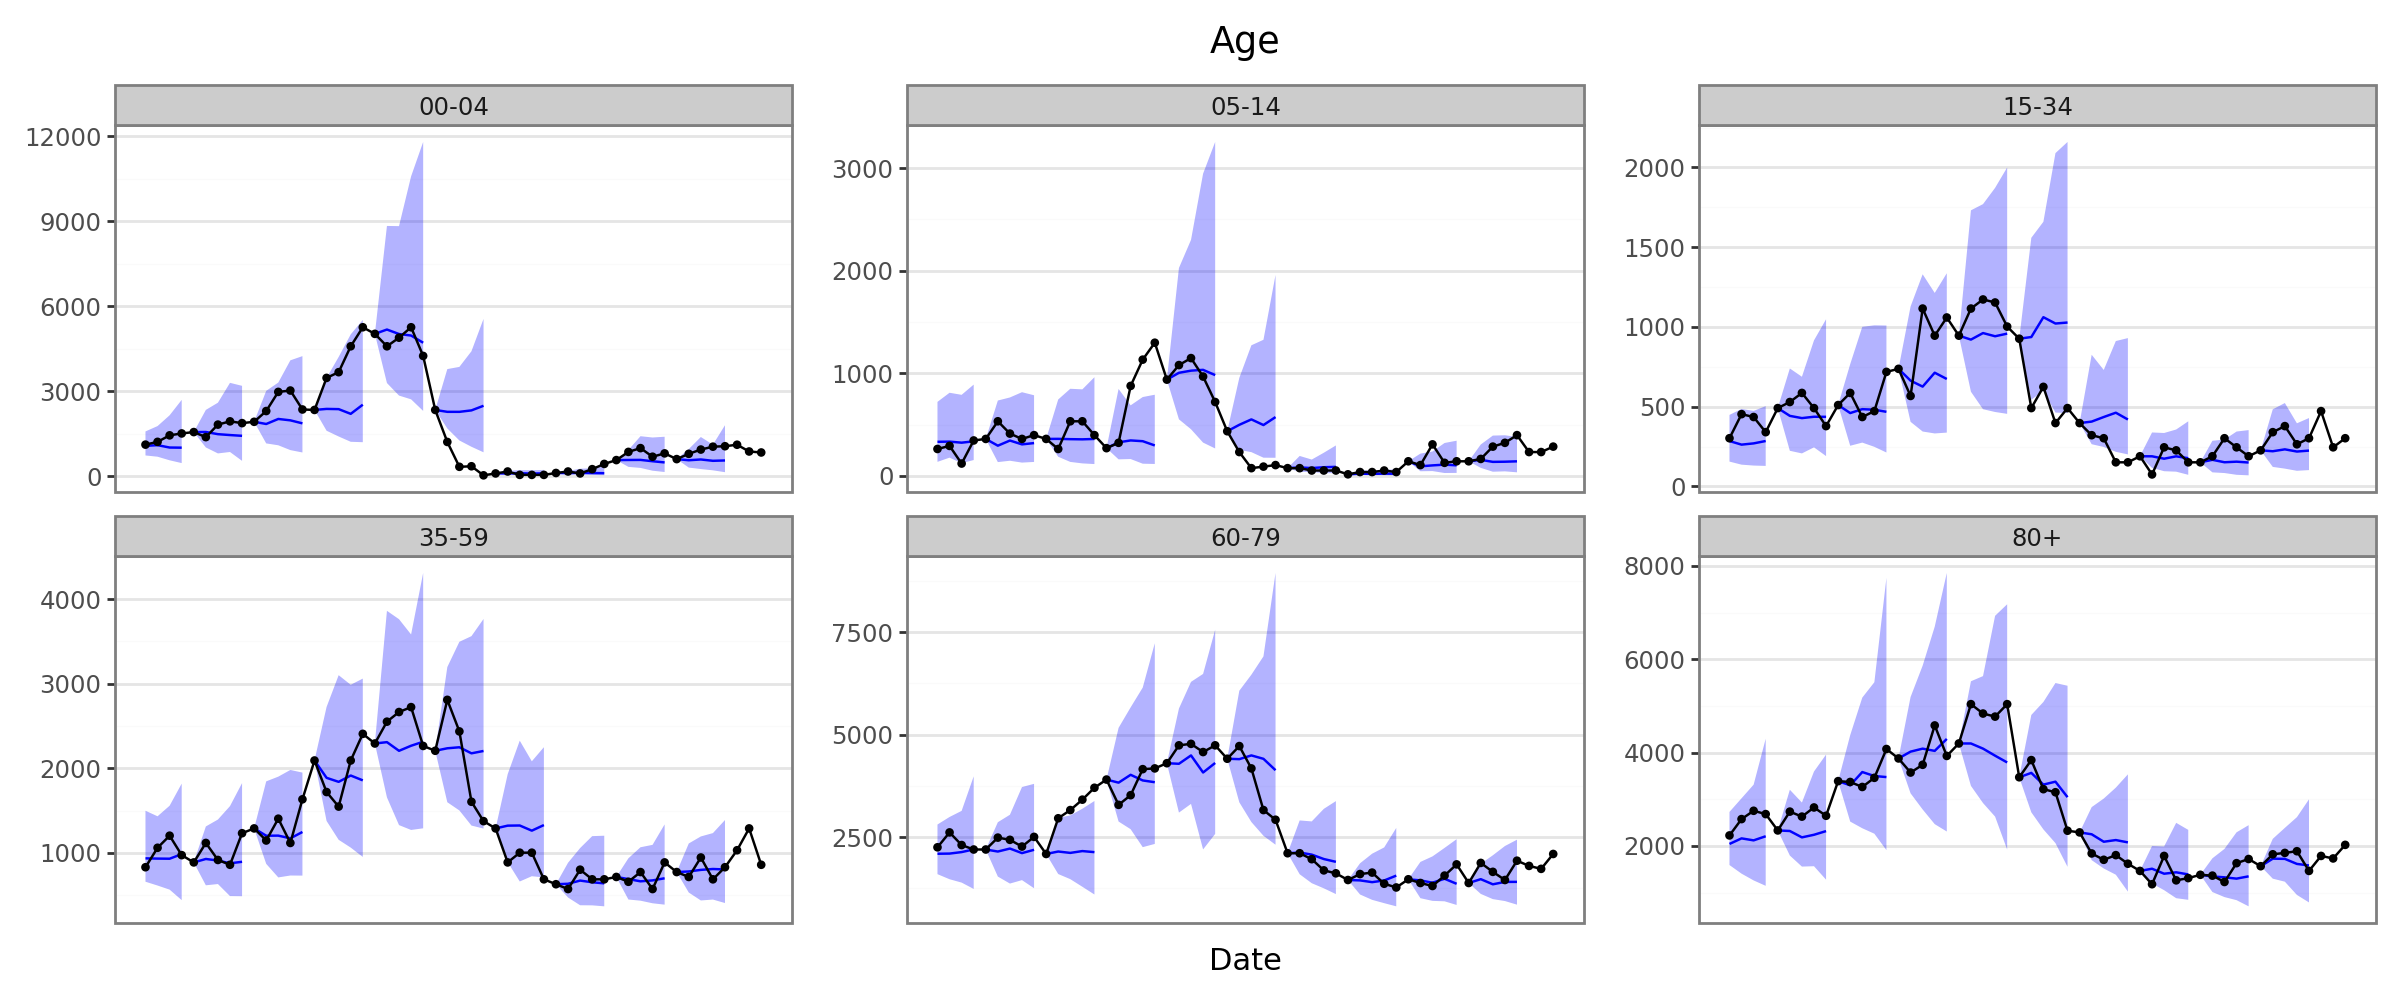

In [18]:
plot_forecasts(df_plot, 'age')

### Without log transformation

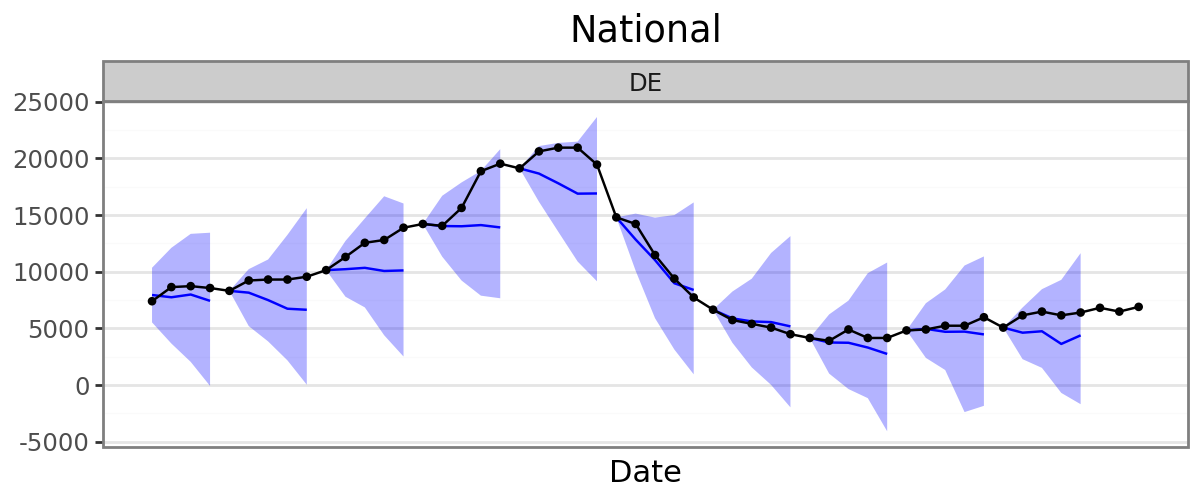

In [24]:
plot_forecasts(df_plot, 'national')

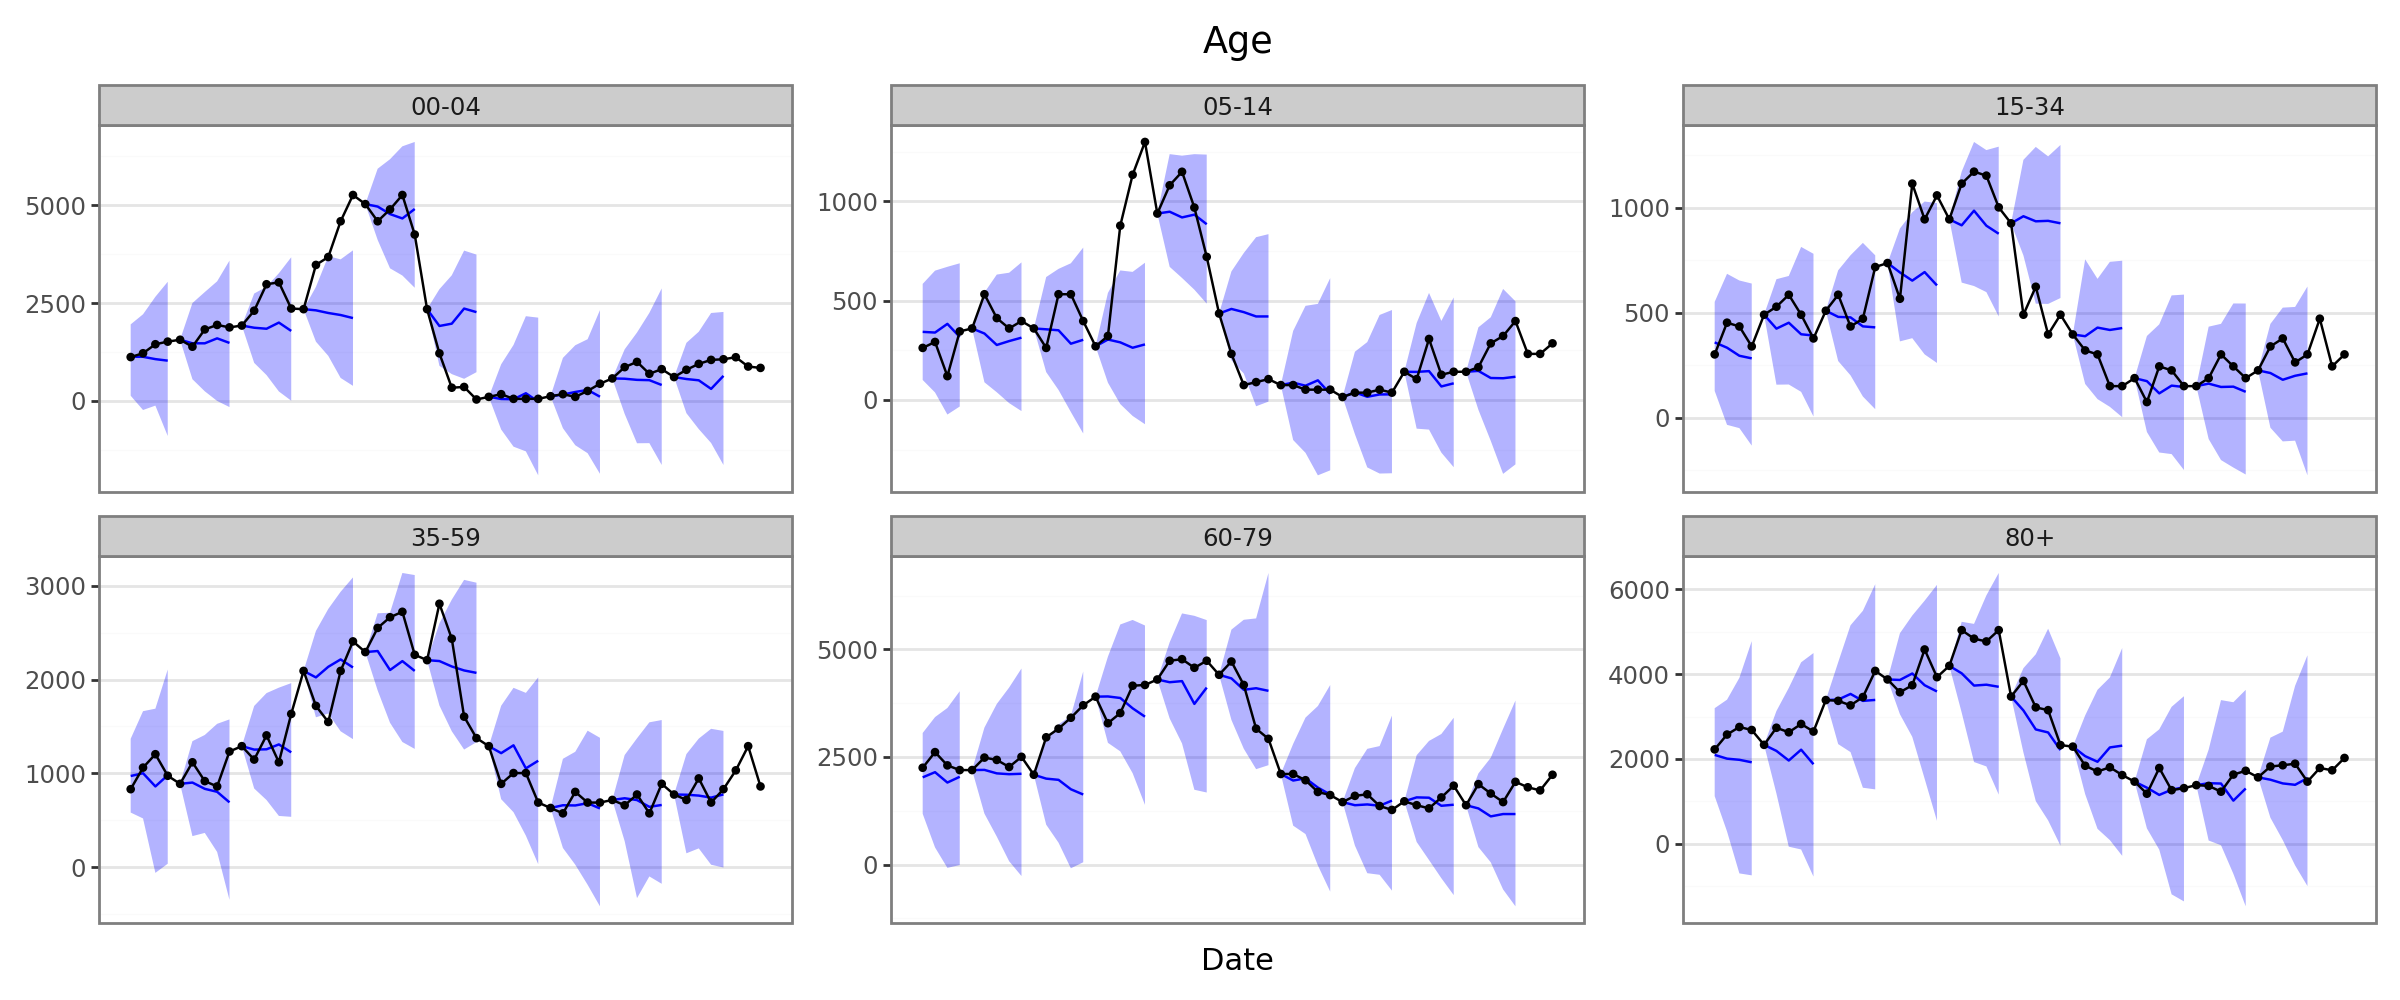

In [25]:
plot_forecasts(df_plot, 'age')